In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from google.colab import drive
drive.mount('/content/gdrive/')
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

Mounted at /content/gdrive/


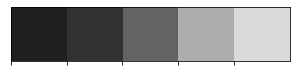

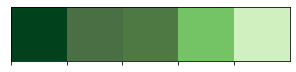

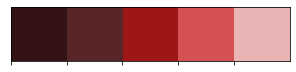

In [3]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [4]:
labels = ['glioma','notumor','meningioma','pituitary']

In [5]:
X_train = []
y_train = []
image_size = 150

In [6]:
for i in labels:
    folderPath = os.path.join('gdrive/MyDrive/Brain_Tumor/New_Brain_Tumor/Training',i)
    for j in tqdm(os.listdir(folderPath), ncols = 120, desc = 'Training: '+str(i)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

Training: pituitary: 100%|██████████████████████████████████████████████████████████| 1457/1457 [00:29<00:00, 49.33it/s]


In [7]:
for i in labels:
    folderPath = os.path.join('gdrive/MyDrive/Brain_Tumor/New_Brain_Tumor/Testing',i)
    for j in tqdm(os.listdir(folderPath), ncols = 120, desc = 'Testing: '+str(i)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

Testing: pituitary: 100%|█████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 68.12it/s]


findfont: Font family ['comic-sans'] not found. Falling back to DejaVu Sans.


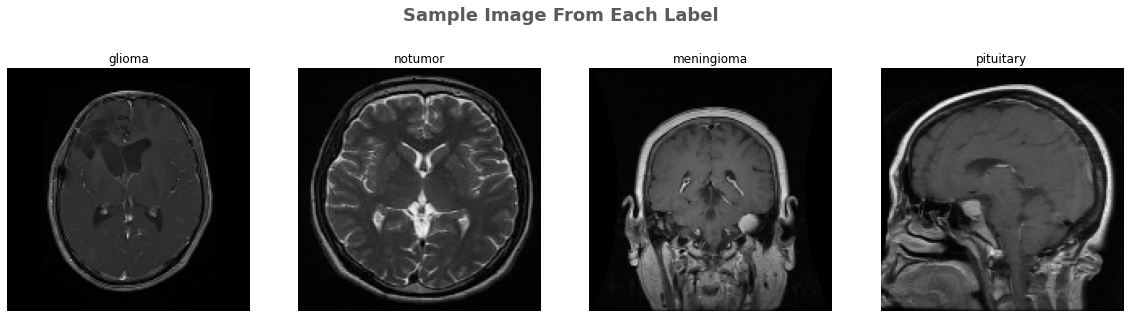

In [8]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='comic-sans',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [9]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [10]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [11]:
print("X_train: ", X_train.shape,'\n',"y_train: ", y_train.shape)

X_train:  (7025, 150, 150, 3) 
 y_train:  (7025,)


In [12]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [13]:
print('X_train-shape:', X_train.shape,'\ny_train-shape: ', y_train.shape, '\nX_tset-shape: ', X_test.shape, '\ny_test-shape: ', y_test.shape)

X_train-shape: (6322, 150, 150, 3) 
y_train-shape:  (6322,) 
X_tset-shape:  (703, 150, 150, 3) 
y_test-shape:  (703,)


In [14]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

In [15]:
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

## **Implementing ResNet50**

In [16]:
resnet = ResNet50(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

94781440/94765736 [==============================] - 1s 0us/step


In [17]:
resnet_model = resnet.output
resnet_model = tf.keras.layers.GlobalAveragePooling2D()(resnet_model)
resnet_model = tf.keras.layers.Dropout(rate=0.5)(resnet_model)
resnet_model = tf.keras.layers.Dense(4,activation='softmax')(resnet_model)
resnet_model = tf.keras.models.Model(inputs=resnet.input, outputs = resnet_model)

In [18]:
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']         

In [19]:
resnet_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [20]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("resnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)

In [ ]:
resnet_history = resnet_model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
 17/178 [=>............................] - ETA: 27:05 - loss: 0.9510 - accuracy: 0.6581

KeyboardInterrupt: ignored

In [ ]:
filterwarnings('ignore')
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = resnet_history.history['accuracy']
train_loss = resnet_history.history['loss']
val_acc = resnet_history.history['val_accuracy']
val_loss = resnet_history.history['val_loss']
fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold', fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)
sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3], label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3], label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3], label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3], label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
fig.show()

In [ ]:
pred = resnet_model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [ ]:
print(classification_report(y_test_new,pred))

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True, cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold', fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)
plt.show()